In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pathlib import Path
from dataclasses import dataclass
from lmfit import Model, minimize, create_params, Parameters
import lmfit
from tqdm.auto import trange

c:\Users\jeppe\Documents\MEGA\Base\DTU\02417 Time Series Analysis\Assignments\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set_theme(style="whitegrid", rc={"figure.figsize": (8, 4)})

DPI_EXPORT = 600
ASSIGNMENT_DIR = Path().resolve()
OUTPUT_DIR = ASSIGNMENT_DIR / "report" / "output"

## 1.1

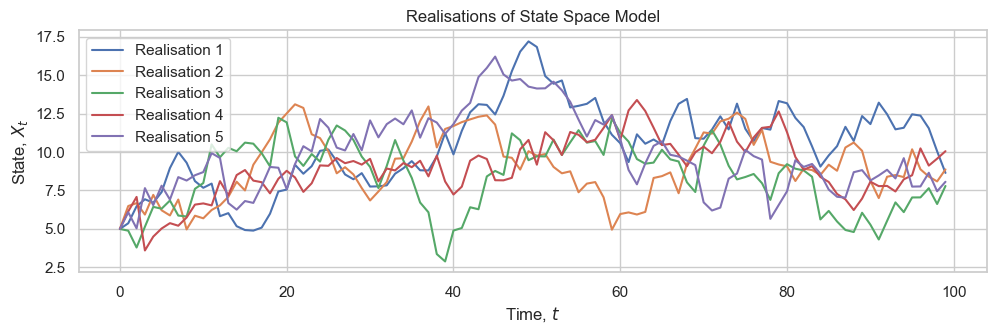

In [3]:
# Make a realisation
def make_realisation(A, B, sigma_1, X_0, n, rng):
    e_1_t = rng.normal(0, sigma_1, n)

    X_t = np.empty(n, dtype=np.float64)
    X_t[0] = X_0
    for i in range(1, n):
        X_t[i] = A * X_t[i - 1] + B + e_1_t[i]

    return X_t


rng = np.random.default_rng(0)
realisations = []
for i in range(5):
    realisations.append(make_realisation(A=0.9, B=1, sigma_1=1, X_0=5, n=100, rng=rng))

# Plot the realisations
plt.figure(figsize=(10, 3.5))
for i, realisation in enumerate(realisations):
    plt.plot(realisation, label=f"Realisation {i + 1}")


plt.title("Realisations of State Space Model")
plt.xlabel("Time, $t$")
plt.ylabel("State, $X_t$")
plt.tight_layout()
plt.legend()

plt.savefig(OUTPUT_DIR / "1_1_realisations.png", dpi=DPI_EXPORT, bbox_inches="tight")


## 1.2


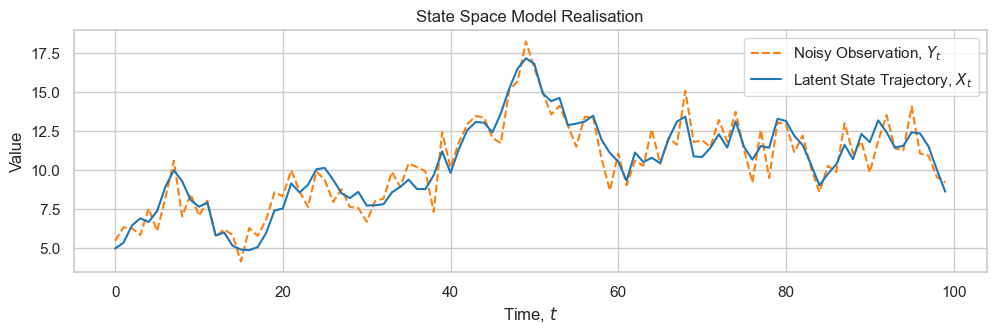

In [4]:
# We now generate the observation vector for a single realisation
def make_observation(X_t, sigma_2, rng):
    e_2_t = rng.normal(0, sigma_2, len(X_t))
    Y_t = X_t + e_2_t
    return Y_t


rng = np.random.default_rng(0)
n = 100
X_t = make_realisation(A=0.9, B=1, sigma_1=1, X_0=5, n=n, rng=rng)
Y_t = make_observation(X_t, sigma_2=1, rng=rng)

plt.figure(figsize=(10, 3.5))
plt.plot(Y_t, label="Noisy Observation, $Y_t$", c="tab:orange", ls="--")
plt.plot(X_t, label="Latent State Trajectory, $X_t$", c="tab:blue")
plt.title("State Space Model Realisation")
plt.xlabel("Time, $t$")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()

plt.savefig(OUTPUT_DIR / "1_2_realisation.png", dpi=DPI_EXPORT, bbox_inches="tight")


## 1.3


array([0.70710678, 0.7643295 , 0.77179389, 0.77277327, 0.77290184,
       0.77291872, 0.77292093, 0.77292122, 0.77292126, 0.77292127,
       0.77292127, 0.77292127, 0.77292127, 0.77292127, 0.77292127,
       0.77292127, 0.77292127, 0.77292127, 0.77292127, 0.77292127,
       0.77292127, 0.77292127, 0.77292127, 0.77292127, 0.77292127,
       0.77292127, 0.77292127, 0.77292127, 0.77292127, 0.77292127,
       0.77292127, 0.77292127, 0.77292127, 0.77292127, 0.77292127,
       0.77292127, 0.77292127, 0.77292127, 0.77292127, 0.77292127,
       0.77292127, 0.77292127, 0.77292127, 0.77292127, 0.77292127,
       0.77292127, 0.77292127, 0.77292127, 0.77292127, 0.77292127,
       0.77292127, 0.77292127, 0.77292127, 0.77292127, 0.77292127,
       0.77292127, 0.77292127, 0.77292127, 0.77292127, 0.77292127,
       0.77292127, 0.77292127, 0.77292127, 0.77292127, 0.77292127,
       0.77292127, 0.77292127, 0.77292127, 0.77292127, 0.77292127,
       0.77292127, 0.77292127, 0.77292127, 0.77292127, 0.77292

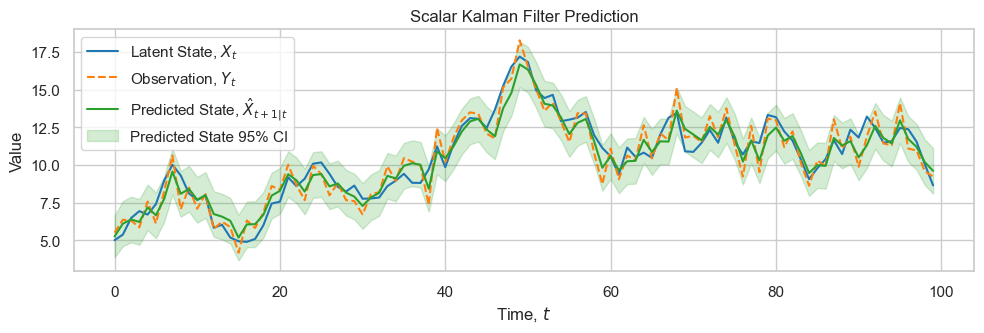

In [5]:
def my_kalman_filter(
    y,  # array-like, observations y_t
    theta,  # (a, b, c), model parameters for state equation
    R,  # measurement noise variance
    x_prior=0.0,  # initial state prior mean
    P_prior=10.0,  # initial state prior variance
):
    a, b, sigma1 = theta
    N = len(y)

    x_pred = np.zeros(N)  # predicted means
    P_pred = np.zeros(N)  # predicted variances
    x_filt = np.zeros(N)  # filtered means
    P_filt = np.zeros(N)  # filtered variances
    innovation = np.zeros(N)  # pre-fit residuals: y[t] - x_pred[t]
    innovation_var = np.zeros(N)  # innovation covariance: P_pred[t] + R

    for t in range(N):
        # Prediction step
        if t == 0:
            x_pred[t] = x_prior
            P_pred[t] = P_prior
        else:
            x_pred[t] = a * x_filt[t - 1] + b
            P_pred[t] = (a**2) * P_filt[t - 1] + sigma1**2

        # Update step
        innovation[t] = y[t] - x_pred[t]
        innovation_var[t] = P_pred[t] + R

        K_t = P_pred[t] / innovation_var[t]  # Kalman gain

        x_filt[t] = x_pred[t] + K_t * innovation[t]
        P_filt[t] = (1 - K_t) * P_pred[t]

    return {
        "x_pred": x_pred,
        "P_pred": P_pred,
        "x_filt": x_filt,
        "P_filt": P_filt,
        "innovation": innovation,
        "innovation_var": innovation_var,
    }


rng = np.random.default_rng(0)
A = 0.9
B = 1
sigma_1 = 1
sigma_2 = 1
n = 100
X_0 = 5
realisation = make_realisation(A=A, B=B, sigma_1=sigma_1, X_0=X_0, n=n, rng=rng)
Y_t = make_observation(realisation, sigma_2=sigma_2, rng=rng)
result = my_kalman_filter(
    y=Y_t, theta=(A, B, sigma_1), R=sigma_2**2, x_prior=X_0, P_prior=sigma_1**2
)

# Plot
plt.figure(figsize=(10, 3.5))
plt.plot(X_t, label="Latent State, $X_t$", c="tab:blue")
plt.plot(Y_t, label="Observation, $Y_t$", c="tab:orange", ls="--")
plt.plot(result["x_filt"], label="Predicted State, $\\hat{X}_{t+1|t}$", c="tab:green")

# Calculate 95% confidence intervals
lower_bound = result["x_filt"] - 1.96 * np.sqrt(result["P_filt"])
upper_bound = result["x_filt"] + 1.96 * np.sqrt(result["P_filt"])
plt.fill_between(
    range(n),
    lower_bound,
    upper_bound,
    color="tab:green",
    alpha=0.2,
    label="Predicted State 95% CI",
)


plt.title("Scalar Kalman Filter Prediction")
plt.xlabel("Time, $t$")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "1_3_kalman_filter.png", dpi=DPI_EXPORT, bbox_inches="tight")

np.sqrt(result["P_filt"])

## 1.4

In [6]:
def my_loglik_fun(theta, y, sigma_2=1.0, x_prior=0.0, P_prior=10.0):
    a, b, sigma1 = theta

    # Call the Kalman filter function
    kf_result = my_kalman_filter(y, theta, sigma_2**2, x_prior, P_prior)
    err = kf_result["innovation"]  # Innovations (y_t - x_pred_t)
    S = kf_result["innovation_var"]  # Innovation variances (P_pred_t + sigma2^2)

    # Compute log-likelihood: sum of log-density of Gaussian innovations
    # For each t: -0.5 * (log(2*pi*S_t) + err_t^2 / S_t)
    logL_terms = -0.5 * (np.log(2 * np.pi * S) + (err**2) / S)
    logL = np.sum(logL_terms)

    return -logL  # Negative log-likelihood for minimization routines


def wrapper(params, Y_t, sigma_2, x_prior, P_prior):
    parvals = params.valuesdict()
    a = parvals["a"]
    b = parvals["b"]
    sigma_1 = parvals["sigma_1"]

    neglog= my_loglik_fun(
        theta=(a, b, sigma_1), y=Y_t, sigma_2=sigma_2, x_prior=x_prior, P_prior=P_prior
    )

    return neglog


params = Parameters()
params.add("a", value=0.5, min=0, max=5)
params.add("b", value=1, min=-5, max=5)
params.add("sigma_1", value=0.5, min=0, max=10)

# Make a realisation
rng = np.random.default_rng(0)
A = 0.9
B = 1
sigma_1 = 1
sigma_2 = 1
n = 1000
X_0 = 5
realisation = make_realisation(A=A, B=B, sigma_1=sigma_1, X_0=X_0, n=n, rng=rng)
Y_t = make_observation(realisation, sigma_2=sigma_2, rng=rng)

result = minimize(
    wrapper,
    params,
    args=(Y_t, sigma_2, X_0, sigma_1**2),
    method="least_squares",
)

result.params
# result.

name,value,initial value,min,max,vary
a,0.88188904,0.5,0.00000000,5.00000000,True
b,1.12272641,1,-5.00000000,5.00000000,True
sigma_1,1.04914152,0.5,0.00000000,10.0000000,True


In [7]:
def do_experiment(a, b, sigma_1, rng):
    n = 100

    X_0 = 5

    N = 100

    datas = []
    for i in trange(N):
        realisation = make_realisation(A=a, B=b, sigma_1=sigma_1, X_0=X_0, n=n, rng=rng)
        Y_t = make_observation(realisation, sigma_2=1, rng=rng)

        result = my_kalman_filter(
            y=Y_t, theta=(a, b, sigma_1), R=1**2, x_prior=X_0, P_prior=sigma_1**2
        )

        result = minimize(
            wrapper,
            params,
            args=(Y_t, sigma_2, X_0, sigma_1**2),
            method="least_squares",
        )

        datas.append(
            {
                "a_true": a,
                "b_true": b,
                "sigma_1_true": sigma_1,
                "sigma_2": 1,
                "x_prior": X_0,
                "P_prior": sigma_1**2,
                "a_est": result.params["a"].value,
                "b_est": result.params["b"].value,
                "sigma_1_est": result.params["sigma_1"].value,
            }
        )

    return pd.DataFrame(datas)

# df = do_experiment(a=0.9, b=1, sigma_1=1, rng=np.random.default_rng(0))

In [ ]:
def do_and_plot_experiment(a, b, sigma_1):
    rng = np.random.default_rng(0)
    df = do_experiment(a, b, sigma_1, rng=rng)

    pretty_renames = {
        "a_est": "$a$",
        "b_est": "$b$",
        "sigma_1_est": "$σ_1$",
    }
    df = df.rename(columns=pretty_renames)
    dfm = df.melt(
        id_vars=["a_true", "b_true", "sigma_1_true", "sigma_2", "x_prior", "P_prior"],
        value_vars=list(pretty_renames.values()),
        var_name="Parameter",
        value_name="Estimate",
    )

    fig, ax = plt.subplots(figsize=(4.5, 4))
    sns.boxplot(dfm, x="Parameter", y="Estimate", ax=ax, showmeans=True, legend=True)

    true_vals = dfm.iloc[0][["a_true", "b_true", "sigma_1_true"]].rename(
        {
            "a_true": "$a$",
            "b_true": "$b$",
            "sigma_1_true": "$σ_1$",
        }
    )
    sns.scatterplot(
        true_vals,
        ax=ax,
        marker="_",
        # ms=10,
        s=500,
        color="tab:red",
        label="True Values",
        zorder=10,
    )

    true_vals.to_dict()
    params_dict = {
        "N": 100,
    }
    params_dict |= true_vals.to_dict()
    title_params = ", ".join([f"{k}={v}" for k, v in params_dict.items()])

    ax.set_title(
    "Parameter Estimates from Maximum Likelihood Estimation\n" +
    title_params
    )

    fig.tight_layout()
    fig.show()

    fig.savefig(
        OUTPUT_DIR / f"1_4_experiment_a_{a}_b_{b}_sigma_1_{sigma_1}.png",
        dpi=DPI_EXPORT,
        bbox_inches="tight",
    )

do_and_plot_experiment(a=0.9, b=1, sigma_1=1)
do_and_plot_experiment(a=0.9, b=0.9, sigma_1=1)  # Note assignment is wrong, see forum
do_and_plot_experiment(a=1, b=0.9, sigma_1=5)

  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\jeppe\Documents\MEGA\Base\DTU\02417 Time Series Analysis\Assignments\.venv\Lib\site-packages\lmfit\minimizer.py:826: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
c:\Users\jeppe\Documents\MEGA\Base\DTU\02417 Time Series Analysis\Assignments\.venv\Lib\site-packages\lmfit\minimizer.py:819: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
  5%|▌         | 5/100 [00:02<00:38,  2.49it/s]c:\Users\jeppe\Documents\MEGA\Base\DTU\02417 Time Series Analysis\Assignments\.venv\Lib\site-packages\lmfit\minimizer.py:825: RuntimeWarning: divide by zero encountered in scalar divide
  par.correl[varn2] = (self.result.covar[ivar, jvar] /
100%|██████████| 100/100 [00:59<00:00,  1.69it/s]
C:\Users\jeppe\AppData\Local\Temp\ipykernel_35184\2058682481.py:52: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
  1%|          | 1/100 [00:01<01:56,  1.17s/

  2%|▏         | 2/100 [00:00<00:07, 12.59it/s]c:\Users\jeppe\Documents\MEGA\Base\DTU\02417 Time Series Analysis\Assignments\.venv\Lib\site-packages\lmfit\minimizer.py:825: RuntimeWarning: divide by zero encountered in scalar divide
  par.correl[varn2] = (self.result.covar[ivar, jvar] /
c:\Users\jeppe\Documents\MEGA\Base\DTU\02417 Time Series Analysis\Assignments\.venv\Lib\site-packages\lmfit\minimizer.py:826: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
c:\Users\jeppe\Documents\MEGA\Base\DTU\02417 Time Series Analysis\Assignments\.venv\Lib\site-packages\lmfit\minimizer.py:819: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
100%|██████████| 100/100 [00:03<00:00, 26.12it/s]
C:\Users\jeppe\AppData\Local\Temp\ipykernel_25960\2796910007.py:52: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


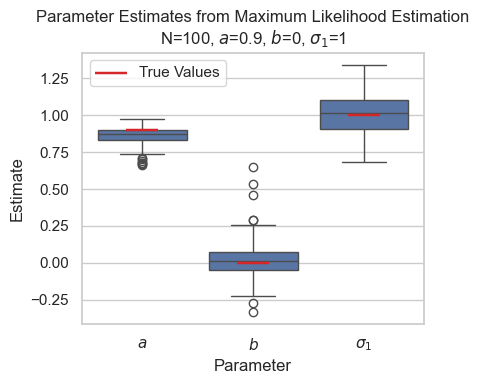

In [ ]:
do_and_plot_experiment(a=0.9, b=0, sigma_1=1)